## Partial Factorial Model: Credit Card Design


Offering the best product to different groups of people is an intricate task. Especially when it comes to credit cards, there are numerous factors that drive the success and failure of the product offered. Hence, a thorough analysis of the demography and the bankruptcy score is indispensable for reducing the risk and improving the profitability of the rollout. Faced with the task of offering the best of the 12 products to the three groups of customers who have Bankruptcy scores of 150, 200, 250 respectively, we began analyzing the past data to find insights about variables like APR, Fixed/Variable rates, and annual fee having the effects on response rates and LTV. 

In [1]:
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

%reload_ext rpy2.ipython

## Data Preparation

In [2]:
# Read in exhibits 1 & 2 from the initially provided data
ex1 = pd.read_excel(
    "data/exhibits.xls",
    sheet_name="exhibit1",
    dtype={
        "date": "category",
        "apr": "float",
        "fixed_var": "category",
        "annual_fee": "int",
        "visamc": "category",
        "nr_mailed": "int",
        "non_resp": "int",
        "resp": "int",
        "bk_score": "int",
        "average_bk": "int",
    },
)

ex2 = pd.read_excel(
    "data/exhibits.xls",
    sheet_name="exhibit2",
    dtype={
        "apr": "float",
        "fixed_var": "category",
        "annual_fee": "int",
        "clv150": "int",
        "clv200": "int",
        "clv250": "int",
    },
)

In [3]:
# ex1.to_csv('data/ex1.csv')

## Q1) Customer Life Time Value

* Customer Lifetime Value varies with BK score because people with higher scores tend to default and resulting in the loss to the organization and vice versa.

* Customer Lifetime Value varies by the product because products that are more profitable to us will be more costly to the customer, defined by a high APR, variable rate, and carries an annual fee. These product attributes will generate more revenue, so the customers that buy these products will have a higher CLV. Contrarily, customers that buy the products with the attributes of low APR, fixed cost, and no annual fee will have a lower CLV.


## Q4) Part I: Experiment Design

We began the task by designing an experiment to choose the best product to offer to each group of customers. The variables like APR, Fixed/Variable rates, and annual fee with levels of 3, 2, and 2 respectively which led to the creation of 12 different products (3 X 2 X 2) were used to find the optimal design. We also included the bankruptcy score with 3 levels as one of the variables so that the number of available combinations is 36 (3 X 2 X 2 X 3). We identified that the design efficiency was 100% for a full factorial design of 36 and the most efficient partial factorial design was 18 trials with an efficiency of  96.5%. 

In [4]:
%%R
result <- radiant.design::doe(
  factors = c(
    "annual_fee; 0; 20", 
    "apr; 14.9; 16.8; 19.8", 
    "fixed_var; Fixed; Variable", 
    "bk_score; 150; 200; 250"
  ), 
  seed = 1234
)
summary(result, eff = TRUE, part = TRUE, full = TRUE)

Experimental design
# trials for partial factorial: 36 
# trials for full factorial   : 36 
Random seed                   : 1234 

Attributes and levels:
annual_fee: 0, 20 
apr: 14.9, 16.8, 19.8 
fixed_var: Fixed, Variable 
bk_score: 150, 200, 250 

Design efficiency:
 Trials D-efficiency Balanced
      7        0.368    FALSE
      8        0.276    FALSE
      9        0.751    FALSE
     10        0.705    FALSE
     11        0.507    FALSE
     12        0.892     TRUE
     13        0.813    FALSE
     14        0.792    FALSE
     15        0.726    FALSE
     16        0.678    FALSE
     17        0.622    FALSE
     18        0.965     TRUE
     19        0.911    FALSE
     20        0.869    FALSE
     21        0.821    FALSE
     22        0.852    FALSE
     23        0.848    FALSE
     24        0.922     TRUE
     25        0.883    FALSE
     26        0.846    FALSE
     27        0.914    FALSE
     28        0.888    FALSE
     29        0.862    FALSE
     30    

### Partial Factorial Design

We chose a partial factorial design for the test as we feel that we can evaluate the response rates of the chosen 18 combinations and then predicting the other combinations using the predictive model rather than testing all the combinations which would cost us 72,000 additional customers in the test run thereby reducing the profitability of the rollout phase.

In [5]:
clv_table = pd.wide_to_long(ex2, stubnames="clv", i="offer", j="bk_score").reset_index()
clv_table = clv_table[["apr", "annual_fee", "fixed_var", "bk_score", "clv"]]

The partial designs with random seeds of `19`, `1234`, and `172110` were created in Radiant and exported as a `CSV` file. Using that data, we explore the results below.

In [6]:
part_19 = pd.read_csv("data/part_19.csv")
part_19 = part_19[["apr", "fixed_var", "annual_fee", "bk_score"]]

part_19_clv = pd.merge(
    part_19,
    clv_table,
    how="left",
    left_on=["apr", "annual_fee", "fixed_var", "bk_score"],
    right_on=["apr", "annual_fee", "fixed_var", "bk_score"],
)
sum(part_19_clv.clv)

1293

In [7]:
part_1234 = pd.read_csv("data/part_1234.csv")
part_1234 = part_1234[["apr", "fixed_var", "annual_fee", "bk_score"]]

part_1234_clv = pd.merge(
    part_1234,
    clv_table,
    how="left",
    left_on=["apr", "annual_fee", "fixed_var", "bk_score"],
    right_on=["apr", "annual_fee", "fixed_var", "bk_score"],
)
sum(part_1234_clv.clv)

1293

In [8]:
part_long = pd.read_csv("data/part_long.csv")
part_long = part_long[["apr", "fixed_var", "annual_fee", "bk_score"]]

part_long_clv = pd.merge(
    part_long,
    clv_table,
    how="left",
    left_on=["apr", "annual_fee", "fixed_var", "bk_score"],
    right_on=["apr", "annual_fee", "fixed_var", "bk_score"],
)
sum(part_long_clv.clv)

1293

## Q4) Part II: Choosing Partial Factorial Model

The sum of CLV is equal for all 3 random seeds: `$1293`. But when looking at experiments generated with different random seeds, the total number of products being rolled out differed. The experiment with the random seed of `1234` only had 10 products, while the other 2 had 12 products. To see whether those products would result in a significant differences in response rates, we built a preliminary model using `exhibit 1` data.

In [9]:
rvar = "response"
evar = ["apr", "fixed_var", "annual_fee", "bk_score"]

form = "response ~ " + " + ".join(evar)

In [10]:
ex1_gathered = pd.read_csv("data/ex1_gathered.csv")
ex1_gathered_ex = pd.read_csv("data/ex1_gathered_expand.csv")

In [11]:
lr = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=ex1_gathered["freq"],
    data=ex1_gathered,
).fit(cov_type="HC1")

In [12]:
ex1_gathered_ex["pred_resp"] = 1 - lr.predict(ex1_gathered_ex)

Text(0.5, 1.0, 'APR vs. Response Rates')

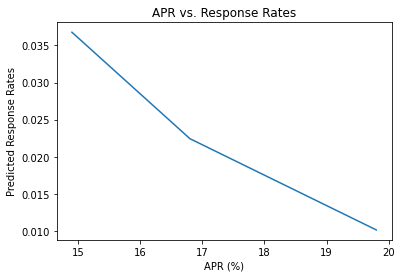

In [59]:
import matplotlib.pyplot as plt

ex1_plot = ex1_gathered_ex.groupby("apr")["pred_resp"].agg("mean")
ex1_plot = pd.DataFrame(ex1_plot)

fig, ax = plt.subplots()
fig = plt.plot(ex1_plot.index, ex1_plot.pred_resp)
ax.set_xlabel("APR (%)")
ax.set_ylabel("Predicted Response Rates")
ax.set_title("APR vs. Response Rates")

From the plot above, we can see that the predictions are considerably lower for an APR of 19.8%, so we are comfortable moving forward with the design which is missing the two models that have an APR of 19.8%, and a random seed of `1234`.

## Q4) Part III: Sample Size for Round 1

We decided to use `4,000` as our sample size for each of the 18 combinations we found from the DOE, because we believed that it would give us a realistic prediction for the response rate without using up too many of our available customers to mail to, but give us a reasonable ability to distinguish between a 2% and a 3% response rate. When testing the effects of the three different random seeds we found that the seeds `19` and `172110` gave us different results than with using seed `1234`. With seeds `19` and `172110` there were 12 possible products to mail to customers while with seed `1234` there were 10. The additional two products which were included both had APRs of `19.8`, and we see the difference in response rates above. So, we reasoned that they would not be rational options to test on since they would not have a high response rate and so we decided to use the seed `1234`.

In [14]:
%%R
result <- radiant.design::sample_size_comp(
  type = "proportion", 
  p1 = 0.02, 
  p2 = 0.03, 
  conf_lev = 0.95, 
  power = 0.8
)
summary(result)

Sample size calculation for comparison of proportions 
Sample size 1    : 3,789
Sample size 2    : 3,789
Total sample size: 7,578
Proportion 1     : 0.02 
Proportion 2     : 0.03 
Effect size      : 0.06437191 
Confidence level : 0.95 
Power            : 0.8 
Alternative      : two.sided 



## Q4) Part IV: Round 1 & Analysis

Using the results from DOE, we mailed 18 combinations: 6 products per bankruptcy score group, and received the response rates, profits, and costs for the mailing.

The total profitability of test run mailing was `$6,727`. Using these results, we built a predictive logistic model, predicting the response rates for all 36 possibilities and estimated the profitability of a customer in a respective group for the offered product using the CLVs from `exhibit 2`. We then identified which of the top 2-3 product offers would give us the highest profitability for each level of bankruptcy score by combining the results of the test run and predictive model and allocated a percentage of the `226,000` remaining customers to each product offered for the input of our rollout stage.


In [15]:
ex1_r1 = pd.read_csv("data/ex1_r1.csv")

# read in gathered data to build predictive model & predict upon
ex1_r1_gathered = pd.read_csv("data/ex1_r1_gathered.csv")
ex1_r1_gathered_ex = pd.read_csv("data/ex1_r1_gathered_expand.csv")

In [16]:
lr_w1 = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=ex1_r1_gathered["freq"],
    data=ex1_r1_gathered,
).fit(cov_type="HC1")

ex1_r1_gathered_ex["pred_resp"] = 1 - lr_w1.predict(ex1_r1_gathered_ex)

## Q4) Part V: Rollout

We began the rollout using the inputs from the predictive model and the test run and received the results of mailing in terms of cumulative profits and mailing costs. The response rates from the rollout were fairly consistent with the predictive model achieving a profit of  `$618,932` and our cumulative profit being `$625,659`.

In [36]:
w2 = ex1_r1_gathered_ex.sort_values(["bk_score", "apr"])
clvs = clv_table.sort_values(["bk_score", "apr"])

In [37]:
w2 = w2.reset_index(drop=True)
clvs = clvs.reset_index(drop=True)

# combine dfs
w2 = pd.merge(w2, clvs, left_index=True, right_index=True)[
    ["apr_x", "fixed_var_x", "annual_fee_x", "bk_score_x", "pred_resp", "clv"]
]

In [47]:
# get predicted CLV from exbhit 2 and predicted response rates
w2["pred_clv"] = w2.pred_resp * w2.clv

# sub-dfs to get top offers
w2_150 = w2.loc[w2.bk_score_x == 150].nlargest(2, "pred_clv")
w2_200 = w2.loc[w2.bk_score_x == 200].nlargest(5, "pred_clv")
w2_250 = w2.loc[w2.bk_score_x == 250].nlargest(3, "pred_clv")

# combined df
w2_list = [w2_150, w2_200, w2_250]
wave_2 = pd.concat(w2_list)
wave_2 = wave_2.reset_index(drop=True).drop([3, 5, 8]).reset_index(drop=True)

In [50]:
# final DF generation
rem = 226000
mail = 0.5
percs = [0.6, 0.4, 0.3, 0.1, 0.6, 0.6, 0.4]

wave_2["perc_mail"] = percs
wave_2["mailing_costs"] = rem * wave_2.perc_mail * mail
wave_2["num_mail"] = rem * wave_2.perc_mail
wave_2["clv_total"] = wave_2.pred_clv * wave_2.num_mail
wave_2["proj_prof"] = wave_2.clv_total - wave_2.mailing_costs

In [51]:
wave_2

,apr_x,fixed_var_x,annual_fee_x,bk_score_x,pred_resp,clv,pred_clv,perc_mail,mailing_costs,num_mail,clv_total,proj_prof
0,14.9,Fixed,0,150,0.043322,52,2.252751,0.6,67800.0,135600.0,305473.087991,237673.087991
1,14.9,Var.,0,150,0.033674,62,2.087816,0.4,45200.0,90400.0,188738.602038,143538.602038
2,14.9,Var.,0,200,0.040502,42,1.701086,0.3,33900.0,67800.0,115333.640595,81433.640595
3,16.8,Fixed,0,200,0.029039,52,1.510014,0.1,11300.0,22600.0,34126.327162,22826.327162
4,14.9,Fixed,20,200,0.016448,63,1.036244,0.6,67800.0,135600.0,140514.626312,72714.626312
5,16.8,Var.,0,250,0.027122,32,0.867907,0.6,67800.0,135600.0,117688.125715,49888.125715
6,19.8,Fixed,0,250,0.013712,50,0.685603,0.4,45200.0,90400.0,61978.487469,16778.487469


We input `num_mail` from the dataframe above into the simulation. And our expected profit is `$624,852.90` for the rollout phase of the simulation. This combined with our initial profits from round 1 and rollout phase mailing expenses would give us a predicted projected profit of `$630,324.90`.

## Q2) Effectiveness of Predictive Models

Predictive models estimated on historical data, in this case, are useful. It is not practical to wait out the lifetime of a customer with a bank, so it makes sense to build models using historical data to classify customers and plan effective offers. Although the model on the past data may not explain the variability due to unexplained factors, it was fair enough to determine the expected response rates for the different products during the test run. Also, the predictive model with inputs from a test run, predicted the response rates of the rollout for the combinations that are not tried out in the test run successfully proving that predictive models estimated on historical data useful in this case.

## Q3) Best Product

The “best product” for all customers would be the one that is least costly to them, given that we are assuming that our customers are rational and they would prefer to pay less for the credit card services, they will want a low APR, fixed-rate, and no annual fee. In our case that would be the combination of low apr, fixed-rate, and no annual fee. The most desirable combination is:
> APR: 14.9%   
> Fixed-rate   
> $0 Annual fee

This fact is validated as the response rates are the highest for this product in all groups when compared to other products both in the predictive model and the rollout results.
